In [2]:
#import needed libs
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
from ast import literal_eval
import calendar

def returnFemalePercentage(string):
    male = 0
    female = 0
    unspecified = 0
    try:
        x = literal_eval(string)
        for i in x:
            if i['gender'] == 1:
                female += 1
            elif i['gender'] == 2:
                male += 1
            elif i['gender'] == 0:
                unspecified +=1
        return ((female / (male + female + unspecified)) * 100)
    except:
        return np.nan
    
#Returns the month from input string
def returnYear(string):
    try:
        return datetime.strptime((string), '%d/%m/%Y').year
    except:
        return np.nan
    
#Method to parse json like genre string and return csv string
def extractGenres(string):
    try:
        x = string.replace("'", '"')
        jsonStr = json.loads(x)
        genres = ""
        for item in jsonStr:
            for key in item:
                if (key == 'name'):
                    genres += item[key] + ','
        return genres[0:(len(genres) - 1)]
    except:
        return ""
    
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res
    

In [3]:
#read in movies data
movies = pd.read_csv("Z:/BDA Datasets/Movies/movies_metadata.csv")

credits = pd.read_csv("Z:/BDA Datasets/Movies/credits.csv")

movies = pd.merge(movies,credits, how='left',left_on='id', right_on='id')

movies = movies.dropna(subset=["cast","crew","genres","release_date"])

#create a new column where csv goes
movies['genre'] = ""
movies['genre'] = movies['genres'].apply(lambda x: extractGenres(x))
#Remove invalid rows
movies = movies[movies['genre'] != '']
movies['genre'] = movies['genre'].str.split(',')
movies = explode(movies, ['genre'])
#Get percentage of female cast
movies['femaleCast'] = movies['cast'].apply(lambda x: returnFemalePercentage(x))
#Get percentage of female crew
movies['femaleCrew'] = movies['crew'].apply(lambda x: returnFemalePercentage(x))

movies = movies.dropna(subset=["femaleCast","femaleCrew"])

#Add Release year
movies['releaseyear'] = movies['release_date'].apply(lambda x: returnYear(x)) 

movies = movies[movies['releaseyear'] >= 1990]
movies = movies[movies['releaseyear'] <= 2017]

[Text(114.0, 0.5, 'Year of Release'),
 Text(0.5, 51.0, 'Movie Genre'),
 Text(0.5, 1, 'Percentage of Female Cast')]

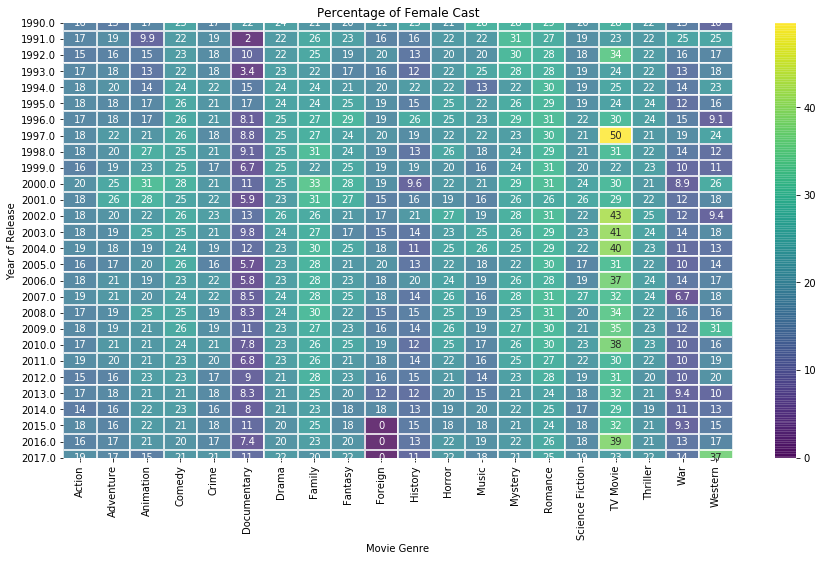

In [6]:
#setting up the plot
fig, ax = plt.subplots(figsize=(15,8))
kwargs = {'alpha':0.8,'linewidth':1, 'linestyle':'--',  "capstyle":'projecting'}
pivot = movies.pivot_table(index='releaseyear', columns='genre', values='femaleCast',fill_value=0)

sns.heatmap(pivot, **kwargs, cmap='viridis', annot=True, ax=ax)

ax.set(xlabel='Movie Genre', ylabel='Year of Release',title='Percentage of Female Cast')


[Text(114.0, 0.5, 'Year of Release'),
 Text(0.5, 51.0, 'Movie Genre'),
 Text(0.5, 1, 'Percentage of Female Crew')]

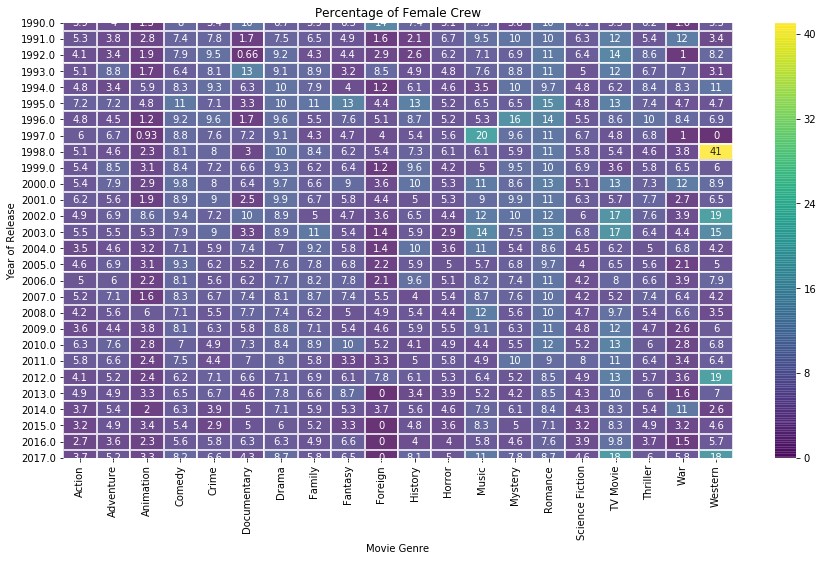

In [7]:

#setting up the plot
fig, ax = plt.subplots(figsize=(15,8))
kwargs = {'alpha':0.8,'linewidth':1, 'linestyle':'--',  "capstyle":'projecting'}
pivot = movies.pivot_table(index='releaseyear', columns='genre', values='femaleCrew',fill_value=0)

sns.heatmap(pivot, **kwargs, cmap='viridis',annot=True, ax=ax)

ax.set(xlabel='Movie Genre', ylabel='Year of Release',title='Percentage of Female Crew')
